# Packages

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate, BatchNormalization
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
plt.style.use('ggplot')
%run Fourier.ipynb # Imports some functions: Heston greeks and L(t,v)
%run Neural_Networks.ipynb # Imports Neural Network
%run Simulation.ipynb # Imports the function to simulate from the Heston model

# Set seed for reproducible results

In [3]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Parameters

In [4]:
# Model parameters 
S0 = 100
K = 100
V0 = 0.2**2
mu = 0.1
sigma = 0.3
kappa = 1
theta = 0.2**2
rho = -0.7
r = 0.05
T = 30/365

# Simulation parameters
steps = 30
dt = T/steps
n_train = 100000
n_test = 10000
#simulation_method = "full truncation" # Choose either "full truncation" or "moment matching" or load data in directly


# Neural Network parameters
epochs = 20
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 3 # Number of hidden layers
n_inputs = 3 # time, logS(t) and the volatility
n_outputs = 2 # delta1 and delta2

In [5]:
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=r, divyield=0, V=V0, theta=theta, kappa=kappa, sigma=sigma, rho=rho, greek=1)
print(callprice)

2.4859242733097773


In [6]:
time_grid = np.linspace(0,T,steps+1)

S1_train = np.load("S1_train.npy")
V_train = np.load("V_train.npy")
S2_train = np.cumsum(np.load("intV_train.npy"),axis=-1)+L(time_grid,V_train)

dS1_train = np.diff(S1_train,1,1)
dS2_train = np.diff(S2_train,1,1)

# Append the two lists alternatingly
dS_train = np.empty(shape=(n_train,2*steps))
dS_train[:,::2] = dS1_train
dS_train[:,1::2] = dS2_train

# Creates training input for NN
input_train = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    S1_input_train = np.reshape(np.log(S1_train[:,i])-np.log(S0),(n_train,1))
    V_input_train = np.reshape(V_train[:,i]-V0,(n_train,1))
    input_train.append(np.concatenate((time_rep,S1_input_train,V_input_train),1))

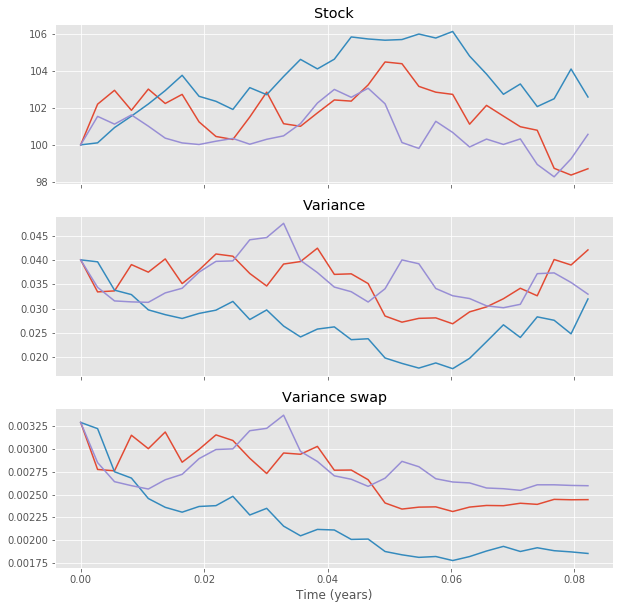

In [7]:
fig, axs = plt.subplots(3)
axs[0].plot(time_grid,S1_train[0],time_grid,S1_train[1],time_grid,S1_train[2])
axs[0].set_title('Stock')
axs[0].label_outer()
axs[1].plot(time_grid,V_train[0],time_grid,V_train[1],time_grid,V_train[2])
axs[1].set_title('Variance')
axs[1].label_outer()
axs[2].plot(time_grid,S2_train[0],time_grid,S2_train[1],time_grid,S2_train[2])
axs[2].set_title('Variance swap')
axs[2].set(xlabel='Time (years)')
axs[2].label_outer()
fig.set_size_inches(10, 10)

#plt.savefig("Hestonpaths.png",dpi=1000,bbox_inches="tight")

In [11]:
def value_pf(y_true,y_pred):
    S1 = S0
    S2 = L(0,V0)
    dS1 = y_true[:,::2]
    dS2 = y_true[:,1::2]
    delta1 = y_pred[:,::2]
    delta2 = y_pred[:,1::2]
    Vpf = callprice 
    B = Vpf - delta1[:,0]*S1-delta2[:,0]*S2
    for i in range(1,steps):
        S1 += dS1[:,i-1]
        S2 += dS2[:,i-1]
        Vpf = delta1[:,i-1]*S1+delta2[:,i-1]*S2+B*kb.exp(r*dt)
        B = Vpf - delta1[:,i]*S1 - delta2[:,i]*S2
    S1 += dS1[:,-1]
    S2 += dS2[:,-1]
    Vpf = delta1[:,-1]*S1+delta2[:,-1]*S2+B*kb.exp(r*dt)
    return Vpf
        
def loss_call(y_true,y_pred):
    return (value_pf(y_true,y_pred) - kb.maximum(S0 + kb.sum(y_true[:,::2],axis=-1) - K,0.))**2

In [12]:
model = FFNN('linear',n_inputs,n_outputs,loss_call, learn_rate,neurons,n_hidden_layers)

In [13]:
#model.summary()

In [14]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)
#model.save('Heston call using var')
#model = tf.keras.models.load_model('Heston call using var', compile=False)

Epoch 1/20
1000/1000 [==============================] - 60s 53ms/step - loss: 0.3177
Epoch 2/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1727
Epoch 3/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1701
Epoch 4/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1671
Epoch 5/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1618
Epoch 6/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1463
Epoch 7/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1369
Epoch 8/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1360
Epoch 9/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1331
Epoch 10/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1321
Epoch 11/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1321
Epoch 12/20
1000/1000 [==============================] - 53s 53

In [15]:
# For network that takes in time, S1 and S2 (useful when variance is unobservable)
input_train2 = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_train)
    time_rep = np.reshape(time_rep,(n_train,1))
    S1_input_train = np.reshape(np.log(S1_train[:,i])-np.log(S0),(n_train,1))
    S2_input_train = np.reshape(S2_train[:,i]-S2_train[:,0],(n_train,1))
    input_train2.append(np.concatenate((time_rep,S1_input_train,S2_input_train),1))

In [29]:
model2 = FFNN('linear',n_inputs,n_outputs,loss_call, learn_rate,neurons,n_hidden_layers)

In [30]:
model2.fit(input_train2,dS_train,batch_size=batch_size,epochs=epochs)
#model2.save('Heston call using S2')
#model2 = tf.keras.models.load_model('Heston call using S2', compile=False)

Epoch 1/20
1000/1000 [==============================] - 60s 53ms/step - loss: 0.3177
Epoch 2/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1761
Epoch 3/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1720
Epoch 4/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1670
Epoch 5/20
1000/1000 [==============================] - 54s 53ms/step - loss: 0.1582
Epoch 6/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1430
Epoch 7/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1379
Epoch 8/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1373
Epoch 9/20
1000/1000 [==============================] - 52s 52ms/step - loss: 0.1343
Epoch 10/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1339
Epoch 11/20
1000/1000 [==============================] - 53s 53ms/step - loss: 0.1336
Epoch 12/20
1000/1000 [==============================] - 53s 53

In [18]:
time = T/2
S1_disc = np.linspace(0.94*S0,1.06*S0,num=steps)
V_disc = np.linspace(0.02,0.14,num=steps)

S1_grid, V_grid = np.meshgrid(S1_disc,V_disc)

delta1_NN = []
delta2_NN = []

for i in range(steps):
    input_plot = []
    for j in range(steps):
        input_plot.append(np.reshape((time,np.log(S1_grid[i,j])-np.log(S0),V_grid[i,j]-V0),(1,3)))
    delta1_NN.append(np.reshape(model.predict(input_plot),(steps*2,))[::2])
    delta2_NN.append(np.reshape(model.predict(input_plot),(steps*2,))[1::2])

delta1_NN = np.array(delta1_NN)
delta2_NN = np.array(delta2_NN)

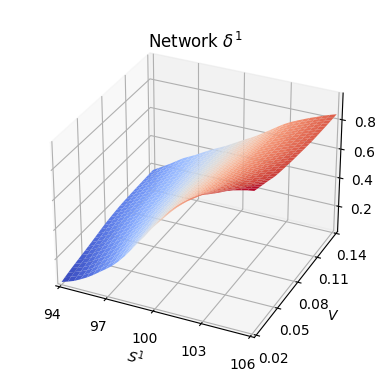

In [24]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta1_NN, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.ticklabel_format(useOffset=False)
    ax.set_title("Network $\delta^1$", y=0.95)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 115)
    ax.dist = 11
    
#plt.savefig("Hestondelta1_NN_4hl200n10e.png", dpi=500,bbox_inches="tight")
plt.show()

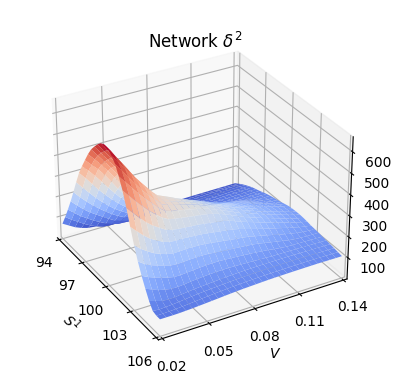

In [25]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid,V_grid, delta2_NN, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.set_title("Network $\delta^2$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    #ax.set_zticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 150)
    ax.dist = 11
    
#plt.savefig("Hestondelta2_NN_4hl200n10e.png", dpi=500,bbox_inches="tight")
plt.show()

In [21]:
delta1_m = vdelta1(S1_grid,V_grid,time)  
delta2_m = vdelta2(S1_grid,V_grid,time)

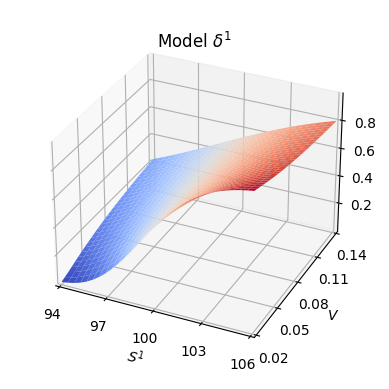

In [26]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta1_m, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    #ax.set_zlabel('delta1')
    ax.set_title("Model $\delta^1$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 115)
    ax.dist = 11
    
#plt.savefig("Hestondelta1_m_3hl200n20e.png", dpi=500,bbox_inches="tight")
plt.show()

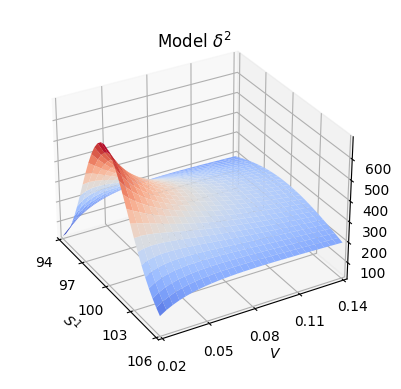

In [27]:
with plt.style.context(['default']):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(S1_grid, V_grid, delta2_m, cmap=cm.coolwarm,linewidth=0)
    ax.set_xlabel('$S^1$')
    ax.set_ylabel('$V$')
    ax.set_title("Model $\delta^2$", y=0.95)
    ax.ticklabel_format(useOffset=False)
    ax.set_xticks([94, 97, 100, 103, 106])
    ax.set_yticks([0.02, 0.05, 0.08, 0.11, 0.14])
    #ax.set_zticks([0.2, 0.4, 0.6, 0.8])
    ax.set_xlim(106, 94)
    ax.set_ylim(0.14,0.02)
    ax.view_init(30, 150)
    ax.dist = 11
    
#plt.savefig("Hestondelta2_m_3hl200n20e.png", dpi=500,bbox_inches="tight")
plt.show()

# Test

## Using variance as input

In [31]:
S1_test = np.load("S1_test.npy")
V_test = np.load("V_test.npy")
S2_test = np.cumsum(np.load("intV_test.npy"),axis=-1)+L(time_grid,V_test)

In [32]:
dS1_test = np.diff(S1_test,1,1)
dS2_test = np.diff(S2_test,1,1)

# Append the two lists alternatingly
dS_test = np.empty(shape=(n_test,2*steps))
dS_test[:,::2] = dS1_test
dS_test[:,1::2] = dS2_test

# Creates test input for NN
input_test = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    S1_input_test = np.reshape(np.log(S1_test[:, i])-np.log(S0),(n_test,1))
    V_input_test = np.reshape(V_test[:,i]-V0,(n_test,1))
    input_test.append(np.concatenate((time_rep,S1_input_test,V_input_test),1))

In [33]:
delta_NN_test = model.predict(input_test)
delta1_NN_test = delta_NN_test[:,::2]
delta2_NN_test = delta_NN_test[:,1::2]

Vpf_NN = callprice
B = Vpf_NN - delta1_NN_test[:,0]*S1_test[:,0]-delta2_NN_test[:,0]*S2_test[:,0]
for i in range(1,steps):
    Vpf_NN = delta1_NN_test[:,i-1]*S1_test[:,i]+delta2_NN_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    B = Vpf_NN - delta1_NN_test[:,i]*S1_test[:,i]-delta2_NN_test[:,i]*S2_test[:,i]
Vpf_NN = delta1_NN_test[:,-1]*S1_test[:,-1]+delta2_NN_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [34]:
S1_grid2 = np.linspace(np.amin(S1_test[:,-1]),np.amax(S1_test[:,-1]),num=1000)
value_call_grid = np.maximum(S1_grid2-K,0)
value_call_true = np.maximum(S1_test[:,-1]-K,0)

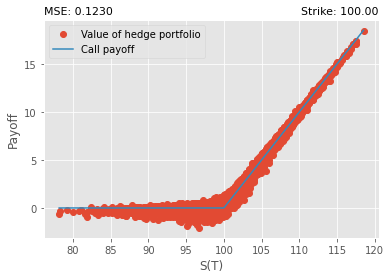

In [60]:
PnL_NN = Vpf_NN - value_call_true
MSE_NN = np.sum(PnL_NN**2)/n_test
plt.figure(figsize=(6,4))
hedge_NN    = plt.plot(S1_test[:,-1],Vpf_NN, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_NN, loc='left', fontsize=11)
plt.legend(loc='upper left')

plt.show()
#plt.savefig("HestonHedge_NN_exact.png", dpi=500,bbox_inches="tight")

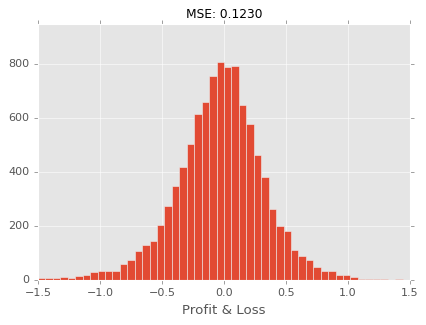

In [61]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_NN,bins=50, range=(-1.5,1.5))
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,950)
plt.show()
#plt.savefig("HestonPnL_NN_exact.png", dpi=500,bbox_inches="tight")

## Using S2 as input

In [37]:
input_test2 = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    S1_input_test = np.reshape(np.log(S1_test[:, i])-np.log(S0),(n_test,1))
    S2_input_test = np.reshape(S2_test[:,i]-S2_test[:,0],(n_test,1))
    input_test2.append(np.concatenate((time_rep,S1_input_test,S2_input_test),1))

In [38]:
delta_NN_test2 = model2.predict(input_test2)
delta1_NN_test2 = delta_NN_test2[:,::2]
delta2_NN_test2 = delta_NN_test2[:,1::2]

Vpf_NN2 = callprice
B = Vpf_NN2 - delta1_NN_test2[:,0]*S1_test[:,0]-delta2_NN_test2[:,0]*S2_test[:,0]
for i in range(1,steps):
    Vpf_NN2 = delta1_NN_test2[:,i-1]*S1_test[:,i]+delta2_NN_test2[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    B = Vpf_NN2 - delta1_NN_test2[:,i]*S1_test[:,i]-delta2_NN_test2[:,i]*S2_test[:,i]
Vpf_NN2 = delta1_NN_test2[:,-1]*S1_test[:,-1]+delta2_NN_test2[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)
Vpf_NN2 = np.array(Vpf_NN2)

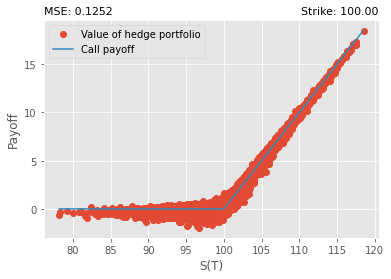

In [64]:
PnL_NN2 = Vpf_NN2 - value_call_true
MSE_NN2 = np.sum(PnL_NN2**2)/n_test
plt.figure(figsize=(6,4))
hedge_NN    = plt.plot(S1_test[:,-1],Vpf_NN2, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_NN2, loc='left', fontsize=11)
plt.legend(loc='upper left')

plt.show()

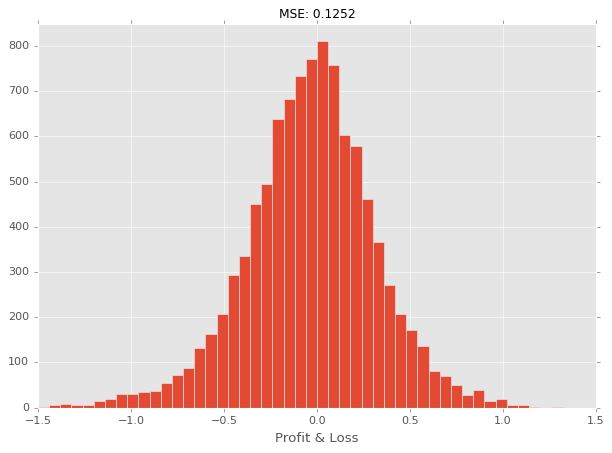

In [65]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_NN2,bins=50, range=(-1.5,1.5))
    plt.title(r'MSE: %1.4f' % MSE_NN2, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,850)
plt.show()

# Comparison to hedging using model deltas

In [41]:
# Either calculate deltas (takes a while) or load them in.

delta1_m_exact = np.load('delta1_m_exact.npy')
delta2_m_exact = np.load('delta2_m_exact.npy')

#delta1_m_exact = np.empty([n_test,steps])
#delta2_m_exact = np.empty([n_test,steps])
#
#for i in range(steps):
#    delta1_m_exact[:,i] = vdelta1(S1_test[:,i],V_test[:,i],i*dt)
#    delta2_m_exact[:,i] = vdelta2(S1_test[:,i],V_test[:,i],i*dt)
#    np.save('delta1_m_exact',delta1_m_exact)
#    np.save('delta2_m_exact',delta2_m_exact)
#    clear_output()
#    print(str(i+1)+' of '+str(steps)+' completed')
#print('Finished.')
#np.save('delta1_m_exact',delta1_m_exact)
#np.save('delta2_m_exact',delta2_m_exact)


In [42]:
Vpf_m = callprice
B = Vpf_m - delta1_m_exact[:,0]*S1_test[:,0]-delta2_m_exact[:,0]*S2_test[:,0]
for i in range(1,steps):
    Vpf_m = delta1_m_exact[:,i-1]*S1_test[:,i]+delta2_m_exact[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    B = Vpf_m - delta1_m_exact[:,i]*S1_test[:,i]-delta2_m_exact[:,i]*S2_test[:,i]
Vpf_m = delta1_m_exact[:,-1]*S1_test[:,-1]+delta2_m_exact[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)

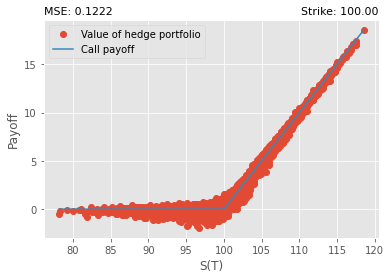

In [62]:
PnL_m = Vpf_m - value_call_true
MSE_m = np.sum(PnL_m**2)/n_test
plt.figure(figsize=(6,4))
hedge_m = plt.plot(S1_test[:,-1],Vpf_m, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_m, loc='left', fontsize=11)
plt.legend()

plt.show()
#plt.savefig("HestonHedge_m_exact.png", dpi=500,bbox_inches="tight")

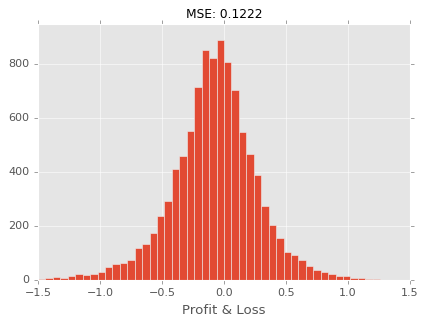

In [63]:
PnL_m = np.array(PnL_m)
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(6,4))
    plt.hist(PnL_m, bins=50,range=(-1.5,1.5))
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,950)
#plt.show()
plt.savefig("HestonPnL_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

# Using approximative variance

## Model deltas

In [67]:
V_approx_test = np.empty([n_test,steps+1])
# Solve S^2(0) = L(0,V0) for V0
V_approx_test[:,0] = (S2_test[:,0]-theta*T)*kappa/(1-np.exp(-kappa*T))+theta

# Approximate and solve for V0
for i in range(1,steps+1):
    time = time_grid[i]
    dSti = S2_test[:,i]-S2_test[:,i-1]
    term2 = -V_approx_test[:,i-1]/2*dt-theta*(T-time)+theta*(1-np.exp(-kappa*(T-time)))/kappa
    term3 = L(time_grid[i-1],V_approx_test[:,i-1])
    denom = dt/2+(1-np.exp(-kappa*(T-time)))/kappa
    V_approx_test[:,i] = (dSti+term2+term3)/denom

In [71]:
delta1_m_approx = np.load('delta1_m_approx.npy')
delta2_m_approx = np.load('delta2_m_approx.npy')

#delta1_m_approx = np.empty([n_test,steps])
#delta2_m_approx = np.empty([n_test,steps])
#
#for i in range(steps):
#    delta1_m_approx[:,i] = vdelta1(S1_test[:,i],V_approx_test[:,i],i*dt)
#    delta2_m_approx[:,i] = vdelta2(S1_test[:,i],V_approx_test[:,i],i*dt)
#    clear_output()
#    print(str(i+1)+' of '+str(steps)+' completed')
#print('Finished.')

#np.save('delta1_m_approx',delta1_m_approx)
#np.save('delta2_m_approx',delta2_m_approx)

In [69]:
Vpf_m_approx = callprice
B = Vpf_m_approx - delta1_m_approx[:,0]*S1_test[:,0]-delta2_m_approx[:,0]*S2_test[:,0]
for i in range(1,steps):
    Vpf_m_approx = delta1_m_approx[:,i-1]*S1_test[:,i]+delta2_m_approx[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    B = Vpf_m_approx - delta1_m_approx[:,i]*S1_test[:,i]-delta2_m_approx[:,i]*S2_test[:,i]
Vpf_m_approx = delta1_m_approx[:,-1]*S1_test[:,-1]+delta2_m_approx[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)

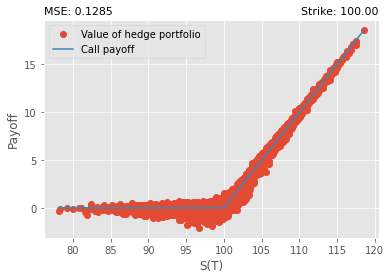

In [72]:
PnL_m_approx = Vpf_m_approx - value_call_true
MSE_m_approx = np.sum(PnL_m_approx**2)/n_test
hedge_m = plt.plot(S1_test[:,-1],Vpf_m_approx, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_m_approx, loc='left', fontsize=11)
plt.legend()

#plt.show()
plt.savefig("HestonCall_m_approx.png", dpi=500,bbox_inches="tight")

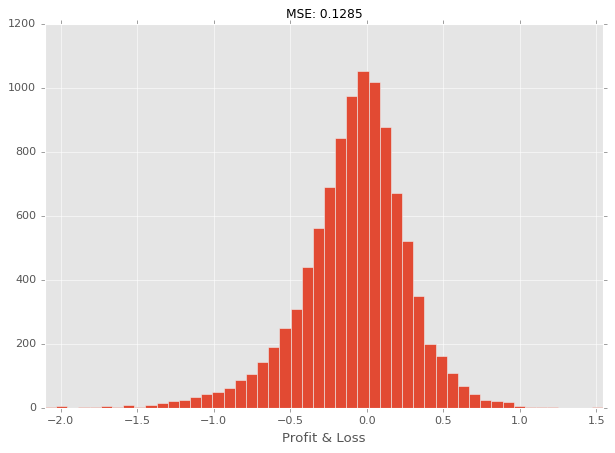

In [75]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_m_approx, bins=50)
    plt.title(r'MSE: %1.4f' % MSE_m_approx, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,1200)
plt.show()
#plt.savefig("HestonPnL_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

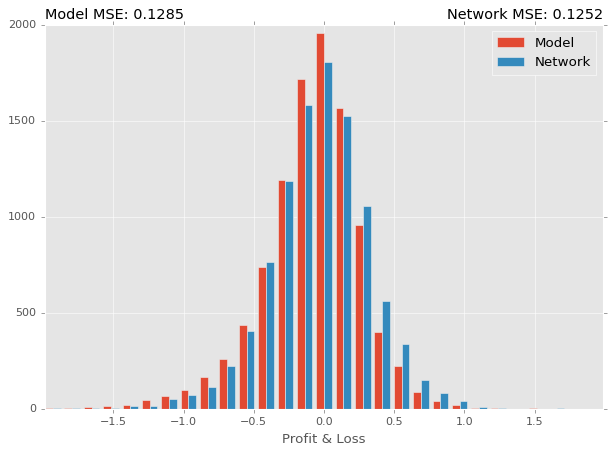

In [80]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-2, 2, 30)
    plt.hist([PnL_m_approx, PnL_NN2], bins, label=['Model', 'Network'])
    plt.legend(loc='upper right')
    plt.xlabel("Profit & Loss")
    plt.title(r'Model MSE: %1.4f' % MSE_m_approx, loc='left', fontsize=13)
    plt.title(r'Network MSE: %1.4f' % MSE_NN2, loc='right', fontsize=13)
    plt.ylim(0, 2000)
plt.show()
#plt.savefig('PnL_approx.png',dpi=500,bbox_inches="tight")